# Решение заочного задания для стажеров 

<div style="text-align: right"> М. М. Шамшиев  </div> 
<div style="text-align: right"> 06.05.2018 </div> 

##  Задача 1.1

<b> Постановка задачи</b>: необходимо построить классификатор, разделяющий изображения двух классов: часы и крокодилы. Набор данных состоит из 500 цветных изображений каждого класса размера 32x32.

В качестве модели для решения данной задачи взята свёрточная нейронная сеть, реализованная с помощью библиотеки PyTorch. 

Для подбора параметров и оценки качества работы модели исходный набор данных был разделен на 3 части: обучающую, валидационную и тестовую. С помощью обучающей и валидационной выборок будет произведен подбор параметров сети, а на изображениях тестовой выборки будет оценено качество предсказания финальной модели.

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils
import torch.optim as optim

import glob
import matplotlib.pyplot as plt
import skimage.io
from sklearn.model_selection import train_test_split

from ConvNetwork import ConvNetAutoEncoder
from ConvNetwork import fit_autoencoder
from ConvNetwork import fit_net
from ConvNetwork import check_accuracy

%matplotlib inline

### Загрузка и подготовка данных

Предполагается, что папки, содержащие изображения, находятся в текущей директории и имеют названия "crocodiles" и "clocks".

In [2]:
crocs = np.array([skimage.io.imread(file) for file in glob.glob("crocodiles/*.png")])
crocs = np.transpose(crocs, (0, 3, 1, 2))

clocks = np.array([skimage.io.imread(file) for file in glob.glob("clocks/*.png")])
clocks = np.transpose(clocks, (0, 3, 1, 2))

Как было обговорено ранее, разобьем исходные данные на три части: обучающую, валидационную и тестовую и приведем их к типу torch.Tensor:

In [3]:
X = np.concatenate((crocs, clocks))
y = np.concatenate((np.zeros(len(crocs), dtype=np.int), np.ones(len(clocks), dtype=np.int)))
full_train, test, full_y_train, y_test = train_test_split(X, y, test_size=0.2)
train, val, y_train, y_val = train_test_split(full_train, full_y_train, test_size=0.2)

In [4]:
test = torch.stack([torch.Tensor(i) for i in test])
val = torch.stack([torch.Tensor(i) for i in val])
train = torch.stack([torch.Tensor(i) for i in train])
y_test = torch.LongTensor(y_test)
y_val = torch.LongTensor(y_val)
y_train = torch.LongTensor(y_train)

Для лучшей сходимости процесса обучения переведем значения всех пикселей в отрезок $[-1, 1]$:

In [5]:
transform = transforms.Normalize((127.5, 127.5, 127.5), (127.5, 127.5, 127.5))

In [6]:
for image in train:
    transform(image)
for image in test:
    transform(image)
for image in val:
    transform(image)    

In [7]:
data_train = torch.utils.data.TensorDataset(train, y_train)
data_test = torch.utils.data.TensorDataset(test, y_test)
data_val = torch.utils.data.TensorDataset(val, y_val)

In [8]:
trainloader = torch.utils.data.DataLoader(data_train, batch_size=4, shuffle=True) 
testloader = torch.utils.data.DataLoader(data_test, batch_size=4, shuffle=True) 
valloader = torch.utils.data.DataLoader(data_val, batch_size=4, shuffle=True)

Вспомагательные функции:

In [9]:
def imshow(img, tensor=True):
    """
    Unnormalize image and show it
    """
    
    if tensor is True:
        npimg = img.numpy()
    else:
        npimg = img
    npimg = npimg * 127.5 + 127.5
    npimg = npimg.astype(np.uint8)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
def loss(net, criterion, loader):
    """
    Calculate loss on the given dataset
    """
    
    loss = 0
    for data in loader:
        images, labels = data
        images, labels = Variable(images), Variable(labels)
        outputs = net(images)
        loss += criterion(outputs, labels).data
    return (loss / len(loader))[0]

In [11]:
criterion = nn.CrossEntropyLoss()

## Подбор параметров

Приступим к подбору параметров модели.  

Учитывая крайне небольшой размер предоставленных данных, подбор параметров за относительно небольшое время можно было бы произвести полным перебором по сеткам значений различных параметров (например, с помощью GridSearchCV из библиотеки scikit-learn). Однако данный подход является невозможным во многих задачах, встречающихся на практике, в виду огромных временных затрат.  

В связи с этим, откажемся от идеи банального полного перебора и попробуем подбирать параметры по очереди: при подборе одного из параметров, остальные будут зафиксированы. Данный подход, естественно, будет уступать полному перебору по качеству подобранных параметров, но зато потребует на порядок меньше вычислительных и временных затрат, а также он является применимым в задачах, где размер обучающей выборки превосходит размер выборки из данной задачи в десятки или сотни раз.

### 0. Число эпох

Прежде чем подбирать параметры сверточной нейронной сети, попробуем сначала "прикинуть" количество эпох, необходимое для обучения модели с помощью стохастического градиентного спуска.

In [12]:
loss_train = []
loss_val = []
epoches = 100
net = ConvNetAutoEncoder(input_size=(3, 32, 32), conv_layers_num=1, conv_out_channels=10, conv_kernel_size=4, 
                         conv_stride=2, pool_kernel_size=2, pool_stride=1)
optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=0.01)
for epoch in range(epoches):
    fit_net(net, optimizer, criterion, trainloader, 1)
    loss_train.append(loss(net, criterion, trainloader))
    loss_val.append(loss(net, criterion, valloader))

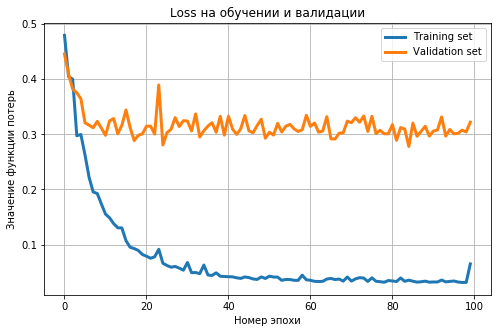

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
ax1.plot(range(epoches), loss_train, lw=3, label='Training set')
ax1.plot(range(epoches), loss_val, lw=3, label='Validation set')
ax1.grid()
ax1.legend()
ax1.set_title("Loss на обучении и валидации")
ax1.set_xlabel("Номер эпохи")
ax1.set_ylabel("Значение функции потерь")
plt.show()

Из первого графика отчетливо видно, что примерно до 15й эпохи значение функции потерь как на обучающей, так и на валидационной выборках уменьшалось. Однако далее лосс-функция на валидационной выборке начала осциллировать вокруг некоторого значения, в то время как значение функции потерь на обучающей выборке ожидаемо продолжало падать. Таким образом, можно сделать вывод, что после примено 15й эпохи, несмотря на уменьшение оптимизируемого функционала, обобщающая способность модели не увеличивалась.

В качестве первого приближения количества эпох для обучения возьмем значение 15.

In [19]:
epoch_num = 15

### 1. Размер ядра свёртки

Подбор параметров сети начнем с подбора размера ядер свёрток. Учитывая небольшой размер изображений (32х32), переберем значения данного параметра по целочисленной сетке от 2 до 9 включительно.

In [24]:
loss_train = [] 
loss_val = []
accuracies_val = []
filt_sizes = range(2, 9)
for size in filt_sizes:
    net = ConvNetAutoEncoder(input_size=(3, 32, 32), conv_layers_num=1, conv_out_channels=5, conv_kernel_size=size, 
                             conv_stride=2, pool_kernel_size=2, pool_stride=1)
    optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=0.01)
    print("Размер фильтра = %d:" % size)
    fit_net(net, optimizer, criterion, trainloader, epoch_num, verbose=True)
    loss_train.append(loss(net, criterion, trainloader))
    loss_val.append(loss(net, criterion, valloader))
    accuracies_val.append(check_accuracy(net, valloader))
    print("Ошибка на валидации: %.3f" % loss_val[-1])
    print("Точность на валидации: %.2f %%" % accuracies_val[-1])
    print("")

Размер фильтра = 2:
[epoch 5] loss: 0.480
[epoch 10] loss: 0.371
[epoch 15] loss: 0.317
Ошибка на валидации: 0.456
Точность на валидации: 82.50 %

Размер фильтра = 3:
[epoch 5] loss: 0.481
[epoch 10] loss: 0.343
[epoch 15] loss: 0.263
Ошибка на валидации: 0.382
Точность на валидации: 84.38 %

Размер фильтра = 4:
[epoch 5] loss: 0.456
[epoch 10] loss: 0.313
[epoch 15] loss: 0.244
Ошибка на валидации: 0.352
Точность на валидации: 85.00 %

Размер фильтра = 5:
[epoch 5] loss: 0.470
[epoch 10] loss: 0.335
[epoch 15] loss: 0.268
Ошибка на валидации: 0.380
Точность на валидации: 83.12 %

Размер фильтра = 6:
[epoch 5] loss: 0.484
[epoch 10] loss: 0.327
[epoch 15] loss: 0.251
Ошибка на валидации: 0.369
Точность на валидации: 84.38 %

Размер фильтра = 7:
[epoch 5] loss: 0.475
[epoch 10] loss: 0.330
[epoch 15] loss: 0.248
Ошибка на валидации: 0.393
Точность на валидации: 83.12 %

Размер фильтра = 8:
[epoch 5] loss: 0.492
[epoch 10] loss: 0.362
[epoch 15] loss: 0.267
Ошибка на валидации: 0.424
Точ

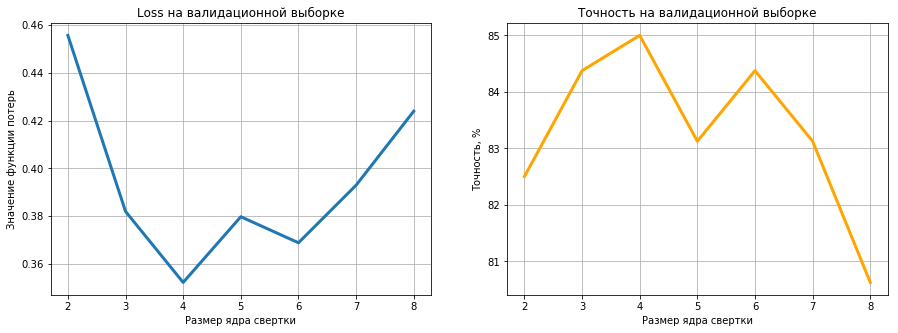

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(filt_sizes, loss_val, lw=3)
ax1.set_title("Loss на валидационной выборке")
ax1.set_xlabel("Размер ядра свертки")
ax1.set_ylabel("Значение функции потерь")
ax1.grid()

ax2.plot(filt_sizes, accuracies_val, lw=3, color='orange')
ax2.set_title("Точность на валидационной выборке")
ax2.set_xlabel("Размер ядра свертки")
ax2.set_ylabel("Точность, %")
ax2.grid()

Исходя из приведенных графиков, можно сделать вывод, что лучшим как с точки зрения значения минимизируемого функционала, так и с точки зрения полученной точности, является значение параметра равное 4.


In [26]:
kernel_size = 4

### 2. Количество фильтров на свёрточном слое

Подбор данного параметра осуществим по целочисленной сетке от 5 до 45 включительно с шагом 5.

In [31]:
loss_train = []
loss_val = []
accuracies_val = []
num_filt = range(5, 45, 5)
for num in num_filt:
    net = ConvNetAutoEncoder(input_size=(3, 32, 32), conv_layers_num=1, conv_out_channels=num, conv_kernel_size=kernel_size, 
                             conv_stride=2, pool_kernel_size=2, pool_stride=1)
    optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=0.01)
    print("Количество фильтров = %d:" % num)
    fit_net(net, optimizer, criterion, trainloader, epoch_num, verbose=True)
    loss_train.append(loss(net, criterion, trainloader))
    loss_val.append(loss(net, criterion, valloader))
    accuracies_val.append(check_accuracy(net, valloader))
    print("Ошибка на валидации: %.3f" % loss_val[-1])
    print("Точность на валидации: %.2f %%" % accuracies_val[-1])
    print("")

Количество фильтров = 5:
[epoch 5] loss: 0.449
[epoch 10] loss: 0.304
[epoch 15] loss: 0.241
Ошибка на валидации: 0.334
Точность на валидации: 86.88 %

Количество фильтров = 10:
[epoch 5] loss: 0.409
[epoch 10] loss: 0.252
[epoch 15] loss: 0.179
Ошибка на валидации: 0.383
Точность на валидации: 85.62 %

Количество фильтров = 15:
[epoch 5] loss: 0.405
[epoch 10] loss: 0.240
[epoch 15] loss: 0.166
Ошибка на валидации: 0.394
Точность на валидации: 85.62 %

Количество фильтров = 20:
[epoch 5] loss: 0.399
[epoch 10] loss: 0.222
[epoch 15] loss: 0.146
Ошибка на валидации: 0.334
Точность на валидации: 85.62 %

Количество фильтров = 25:
[epoch 5] loss: 0.386
[epoch 10] loss: 0.221
[epoch 15] loss: 0.154
Ошибка на валидации: 0.344
Точность на валидации: 86.25 %

Количество фильтров = 30:
[epoch 5] loss: 0.389
[epoch 10] loss: 0.205
[epoch 15] loss: 0.137
Ошибка на валидации: 0.304
Точность на валидации: 87.50 %

Количество фильтров = 35:
[epoch 5] loss: 0.361
[epoch 10] loss: 0.187
[epoch 15] l

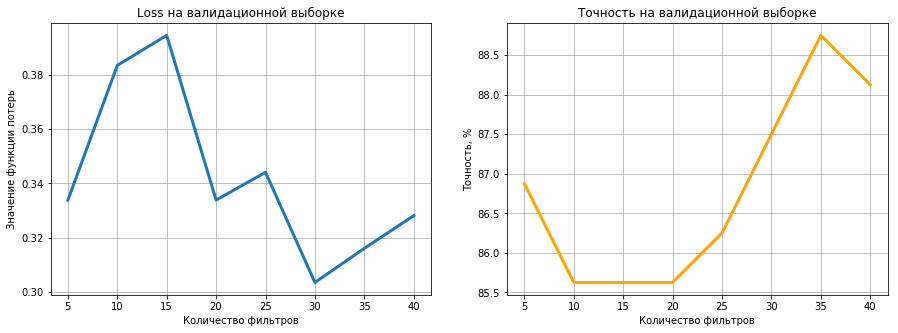

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(num_filt, loss_val, lw=3)
ax1.set_title("Loss на валидационной выборке")
ax1.set_xlabel("Количество фильтров")
ax1.set_ylabel("Значение функции потерь")
ax1.grid()

ax2.plot(num_filt, accuracies_val, lw=3, color='orange')
ax2.set_title("Точность на валидационной выборке")
ax2.set_xlabel("Количество фильтров")
ax2.set_ylabel("Точность, %")
ax2.grid()

Исходя из полученных графиков, можно сделать вывод, что качество работы модели до какого-то момента улучшалось с увеличением количества фильтров. Это логично, ведь при увеличении количества фильтров сеть усложняется и, возможно, становится способна улавливать закономерности в данных, которые раньше не могла заметить. Однако при избыточной сложности модели повышается вероятность столкнуться с переобучением.

Выберем значение параметра количества фильтров на свёрточном слое равным 35.

In [33]:
conv_num = 35

### 3. Количество сверточных блоков

Попробуем использовать свёрточные сети, в архитектуру которых входит больше одного свёрточного блока.
Будем добавлять свёрточные блоки с уже подобранными ранее значениями параметров, но положим значения параметра stride сверток равным 1 (а не 2, как это было ранее), поскольку иначе изображения сожмутся до совсем малых размеров и качество заметно упадёт.

In [34]:
loss_train = []
loss_val = []
accuracies_val = []
num_blocks = range(2, 4)
for num in num_blocks:
    net = ConvNetAutoEncoder(input_size=(3, 32, 32), conv_layers_num=num, conv_out_channels=conv_num, 
                             conv_kernel_size=kernel_size, conv_stride=[2] + [1] * (num - 1), pool_kernel_size=2, 
                             pool_stride=1)
    optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=0.01)
    print("Количество блоков = %d:" % num)
    fit_net(net, optimizer, criterion, trainloader, epoch_num, verbose=True)
    loss_train.append(loss(net, criterion, trainloader))
    loss_val.append(loss(net, criterion, valloader))
    accuracies_val.append(check_accuracy(net, valloader))
    print("Точность на валидации: %.2f %%" % accuracies_val[-1])
    print("Ошибка на валидации: %.3f" % loss_val[-1])
    print("")

Количество блоков = 2:
[epoch 5] loss: 0.437
[epoch 10] loss: 0.278
[epoch 15] loss: 0.180
Точность на валидации: 83.75 %
Ошибка на валидации: 0.370

Количество блоков = 3:
[epoch 5] loss: 0.530
[epoch 10] loss: 0.347
[epoch 15] loss: 0.253
Точность на валидации: 82.50 %
Ошибка на валидации: 0.372



Итак, добавление свёрточных блоков к архитектуре нейронной сети не привело к улучшению качества модели.

### 4. Финальная модель

Объедим обучающую и валидационную части датасета, обучим модель с подобранными значениями параметров и посмотрим на точность на тестовом множестве.

In [35]:
full_train = torch.cat((train, val))
full_y_train = torch.cat((y_train, y_val))
data_full_train = torch.utils.data.TensorDataset(full_train, full_y_train)
fulltrainloader = torch.utils.data.DataLoader(data_full_train, batch_size=4, shuffle=True) 

In [36]:
net = ConvNetAutoEncoder(input_size=(3, 32, 32), conv_layers_num=1, conv_out_channels=conv_num, conv_kernel_size=kernel_size, 
                         conv_stride=2, pool_kernel_size=2, pool_stride=1)
optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=0.01)

In [37]:
fit_net(net, optimizer, criterion, fulltrainloader, epoch_num, verbose=True)

[epoch 5] loss: 0.364
[epoch 10] loss: 0.192
[epoch 15] loss: 0.130


0.1303722579298774

In [38]:
check_accuracy(net, testloader)

91.0

Итак, построенная модель продемонстрировала точность на тестовой выборке равную 91%.

### 5. Возможные способы улучшения результатов 

1. При выполнении данного задания были подобраны далеко не все параметры модели: такие параметры, как, например, stride и padding как свёрточного, так и pooling-слоя использовались со значениями по умолчанию.  
Это связано с тем, что при выполнении данного задания преследовалась цель скорее продемонстрировать навыки и умения работы со свёрточными нейронными сетями, нежели достигнуть очень высокого качества работы модели.

2. Как упоминалось ранее, в виду небольшого размера выборки для данной задачи можно было использовать банальный полный перебор по различным значениям параметров. Скорее всего, построенная с помощью данного подхода модель продемонстрировала бы лучшие результаты работы на тестовой выборки.

3. Использовать более "продвинутые" оптимизационные алгоритмы нейронных сетей по сравнению с обычным стохастическим градиентым спуском (например, градиентный спуск с моментумом либо Adam).

4. Использование кросс-валидации при подборе параметров, возможно, также улучшило бы результаты финальной модели.


## Задача 1.2

<b> Постановка задачи</b>: найти изображения, похожие и на крокодила, и на часы одновременно.  

<b> Идея решения</b>: обучить свёрточный автокодировщик, получить латентные представления изображений и далее с помощью какой-либо метрики найти наиболее близкие изображения разных классов.

Загрузим и подготовим все изображения из предоставленной выборки.

In [73]:
data_full = np.concatenate((train, val, test))
y_data_full = np.concatenate((y_train, y_val, y_test))
data = torch.stack([torch.Tensor(i) for i in data_full])
y_data = torch.LongTensor(y_data_full)

In [74]:
data = torch.utils.data.TensorDataset(data, y_data)
dataloader = torch.utils.data.DataLoader(data, batch_size=4, shuffle=True)

Обучение автокодировщика:

In [44]:
from ConvNetwork import fit_autoencoder

In [50]:
autoencoder = ConvNetAutoEncoder(input_size=(3, 32, 32), conv_layers_num=1, conv_out_channels=10, conv_kernel_size=4, conv_stride=1, 
                                 conv_padding=2, pool_kernel_size=2, pool_stride=2)
optimizer = optim.SGD(autoencoder.parameters(), lr=0.01, weight_decay=0.01)
criterion = nn.MSELoss()

In [52]:
fit_autoencoder(autoencoder, optimizer, criterion, dataloader, 50)

[epoch 5] loss: 0.054
[epoch 10] loss: 0.040
[epoch 15] loss: 0.032
[epoch 20] loss: 0.028
[epoch 25] loss: 0.026
[epoch 30] loss: 0.025
[epoch 35] loss: 0.024
[epoch 40] loss: 0.024
[epoch 45] loss: 0.023
[epoch 50] loss: 0.023


0.022859523087739943

Визулизируем результаты работы автокодировщика.

In [111]:
it = iter(dataloader)
images, _ = next(it)

Исходные изображения:

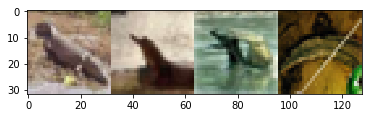

In [112]:
grid = torchvision.utils.make_grid(torch.stack([torch.Tensor(image) for image in images]), padding=0)
imshow(grid, tensor=True)

In [113]:
images = autoencoder(Variable(images), autoencoder=True).data

Изображения после применения автокодировщика:

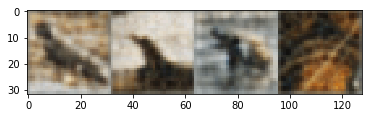

In [114]:
grid = torchvision.utils.make_grid(torch.stack([torch.Tensor(image) for image in images]), padding=0)
imshow(grid, tensor=True)

Теперь с помощью обученного автокодировщика переведем изображения выборки в латентные признаковые представления:

In [63]:
encoded_shape = autoencoder.encode(Variable(images)).data.numpy().shape[1:]

In [75]:
loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False) 
encoded_crocs = np.empty((0,) + encoded_shape)
encoded_clocks = np.empty((0,) + encoded_shape)
for batch in loader:
    images, label = batch
    images = Variable(images)
    if label[0] == 0:
        encoded_crocs = np.vstack((encoded_crocs, autoencoder.encode(images).data.numpy()))
    else:
        encoded_clocks = np.vstack((encoded_clocks, autoencoder.encode(images).data.numpy()))

Между объектами двух классов в новом признаковом пространстве посчитаем попарные евклидовые расстояния:

In [76]:
from scipy.spatial.distance import cdist

In [77]:
distances = cdist(encoded_crocs.reshape(encoded_crocs.shape[0], -1), encoded_clocks.reshape(encoded_clocks.shape[0], -1))

In [81]:
indexes = np.unravel_index(np.argpartition(distances.ravel(), 5)[:5], distances.shape)

Провизуализируем 5 наиболее близких пар объектов разных классов:

In [85]:
images = np.concatenate((train, val, test))
labels = np.concatenate((y_train, y_val, y_test))

In [86]:
crocks = images[labels == 0][indexes[0]]

In [87]:
clocks = images[labels == 1][indexes[1]]

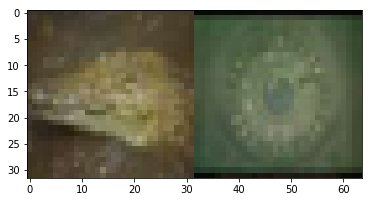

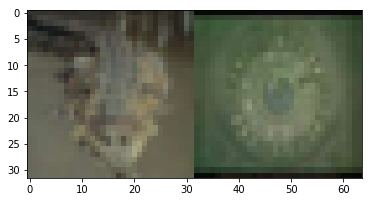

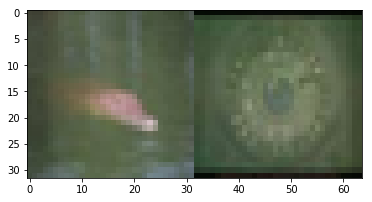

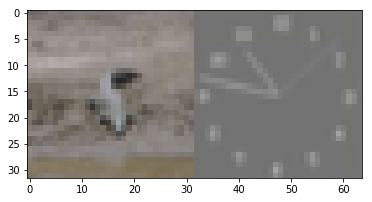

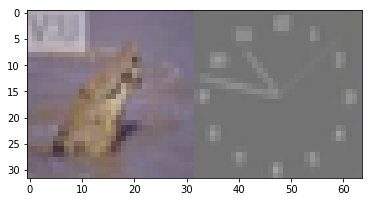

In [99]:
for crock, clock in zip(crocks, clocks):
    imshow(torchvision.utils.make_grid(torch.stack([torch.Tensor(crock), torch.Tensor(clock)]), padding=0), tensor=True)

Результаты работы модели оставляют желать лучшего: большинство изображений человек однозначно классифицирует как часы или крокодил. С другой стороны, в связи с небольшим размером датасета, возможно в нем просто отсутствуют изображения, которые похожи и на часы, и на крокодила больше, чем приведенные выше.  

Хочется отметить, что, несмотря на визуальную непохожесть, изображения в парах преимущественно из одной цветовой гаммы. Возможно поэтому модель выдала эти пары в качестве ответа. 

Также, изображение часов из первых трех пар при небольшом желании можно спутать, например, с глазом крокодила :)

## Возможные способы улучшения результатов:

1. Вместо евклидовой метрики попробовать использовать другие (например, косинусную).
2. Вместо подсчёта попарных расстояний между объектами разных классов, попробовать сначала найти некоторые "средние" изображения
крокодила и часов. Например, это можно сделать, посчитав центроиды каждого класса в новом признаковом представлении. Далее искать наиболее близкие к центроиду одного класса объекты другого класса.